# Parrot Data Exploration

This is data from a single-threaded run of the first 5ms of our 6 spec benchmarks.

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

In [2]:
# Globals you may change
DATA_DIR = 'parrot-traces'

In [3]:
# Globals that you should not touch
FILES = [p.absolute() for p in pathlib.Path(DATA_DIR).iterdir()]

In [4]:
def getData(path):
    return pd.read_csv(path, delim_whitespace=True)

def getName(path):
    return path.stem.split('_')[2]

def allData():
    return pd.concat([getData(path).assign(benchmark=getName(path)) for path in FILES])

def iterData():
    for f in FILES:
        yield {'name':getName(f), 'data':getData(f)}

In [5]:
# Another global you shouldn't touch
MAX_PHASE = max(allData()['phase'])

In [6]:
for data in iterData():
    print(data['name'])

621.wrf
623.xalancbmk
641.leela
605.mcf
654.roms
607.cactuBSSN


# Latency Plots

Stack plots, plot a point for each latency, color by phase

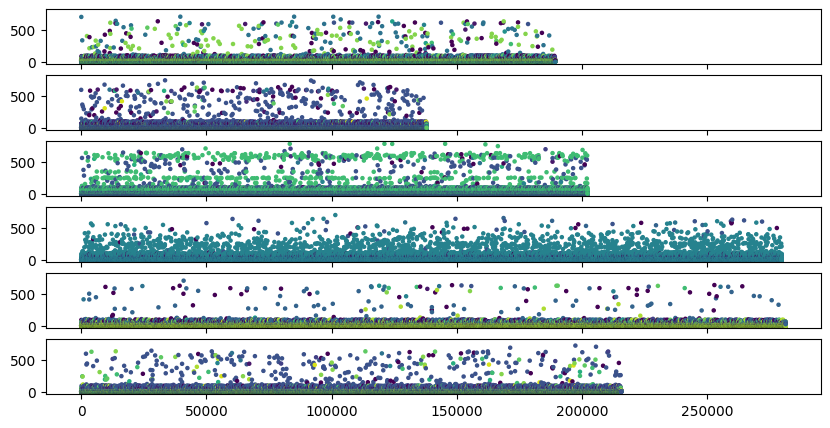

In [45]:
def plot1(ax, data):
    #norm = matplotlib.colors.Normalize(vmin=-1,vmax=MAX_PHASE)
    #norm_phase = [norm(p) for p in data['data']['phase']]
    #phase_vals = range(-1,MAX_PHASE+1)
    #cmap, norm = matplotlib.colors.from_levels_and_colors(phase_vals, plt.cm.viridis(phase_vals), extend='min')
    #cmap, norm = matplotlib.colors.from_levels_and_colors(*range(-1,MAX_PHASE), ['red', 'green', 'blue'])
    norm  = matplotlib.colors.Normalize(vmin=-1, vmax=MAX_PHASE, clip=True)
    ax.plot(data['data']['latency_nano'], color=viridis(norm(data['data']['phase'])))#, cmap=cmap, norm=norm)
    
def plot2(ax, data):
    colormap = plt.cm.viridis #or any other colormap
    normalize = matplotlib.colors.Normalize(vmin=-1, vmax=15)
    ax.scatter([*range(0,len(data['data']['latency_nano']))], data['data']['latency_nano'], c=data['data']['phase'], s=5, cmap=colormap, norm=normalize)
    
fig, axs = plt.subplots(nrows=len(FILES), sharex=True, sharey=True)
for ax, data in zip(axs, iterData()):
    data['data'] = data['data'].sample(frac=.1)
    plot2(ax, data)

fig.set_size_inches((10,5))
plt.show()

# Empirical Distribution Function

Let's look at the ECDF of each phase for each benchmark.

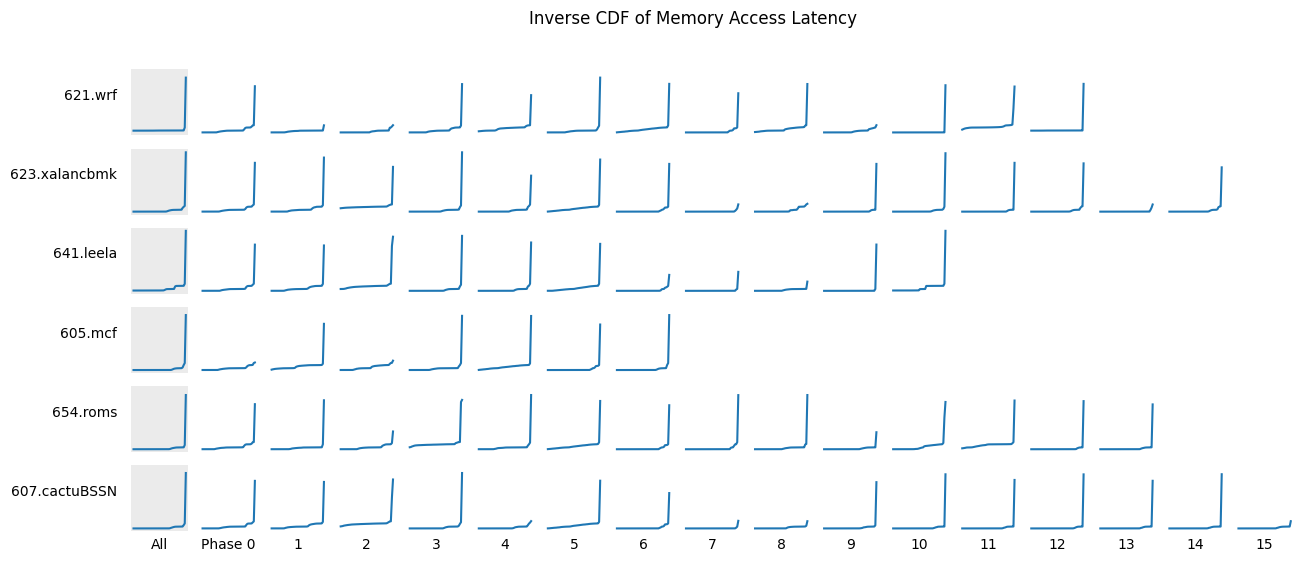

In [195]:
def subsetPhase(df, phase_id):
    return df[df['phase'] == phase_id]

def goTufte(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def plot4(ax, data):
    ax.plot(sorted(data['latency_nano']))
    goTufte(ax)
    
    
def plot3(ax, data):
    ecdf = ECDF(data['latency_nano'])
    ax.plot(ecdf.x, ecdf.y)
    goTufte(ax)
    
def plot_inverse_cdf(ax, data):
    ecdf = ECDF(data['latency_nano'])
    
    slope_changes = sorted(set(data['latency_nano']))
    
    sample_edf_values_at_slope_changes = [ ecdf(item) for item in slope_changes]
    inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)
    x = np.linspace(0.5, 1)
    y = inverted_edf(x)
    
    ax.plot(x,y)
    goTufte(ax)


def plotRow(axs, data, rowmax, plotter):
    df = data['data']
    name = data['name']
    axs[0].set_ylabel(name, rotation=0, labelpad=10, ha='right')
    plotter(axs[0], df)
    nphase = max(df['phase'])
    for i in range(nphase+1):
        plotter(axs[i+1], subsetPhase(df, i))
    for i in range(nphase+2,rowmax):
        goTufte(axs[i])


def latencyPerPhase(plotter, title):
    fig, axs = plt.subplots(nrows=len(FILES), ncols=MAX_PHASE+2, sharey=True)
    for i,data in enumerate(iterData()):
        
        plotRow(axs[i], data, MAX_PHASE+2, plotter)
        axs[i][0].set_facecolor('#ebebeb')
        
        if i == len(FILES)-1:
            axs[i][0].set_xlabel('All')
            axs[i][1].set_xlabel('Phase 0')
            for j in range(2,MAX_PHASE+2):
                axs[i][j].set_xlabel(j-1)
                
    fig.set_size_inches((MAX_PHASE, nrows))
    plt.suptitle(title)
    plt.show()
    
latencyPerPhase(plot_inverse_cdf, 'Inverse CDF of Memory Access Latency')

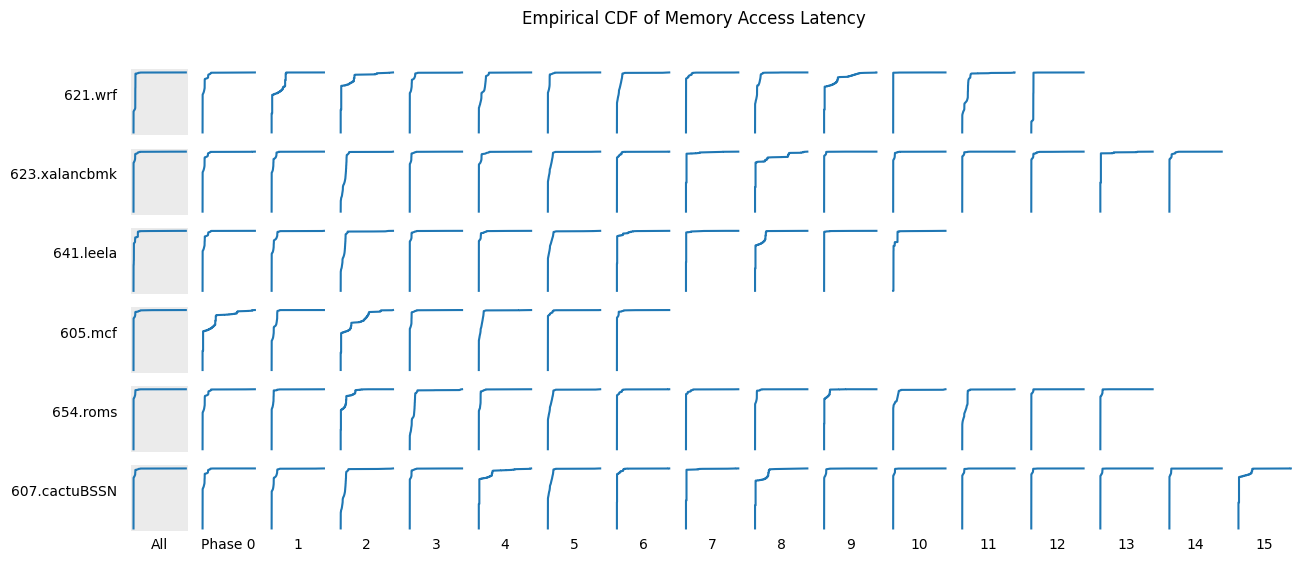

In [186]:
latencyPerPhase(plot3, 'Empirical CDF of Memory Access Latency')

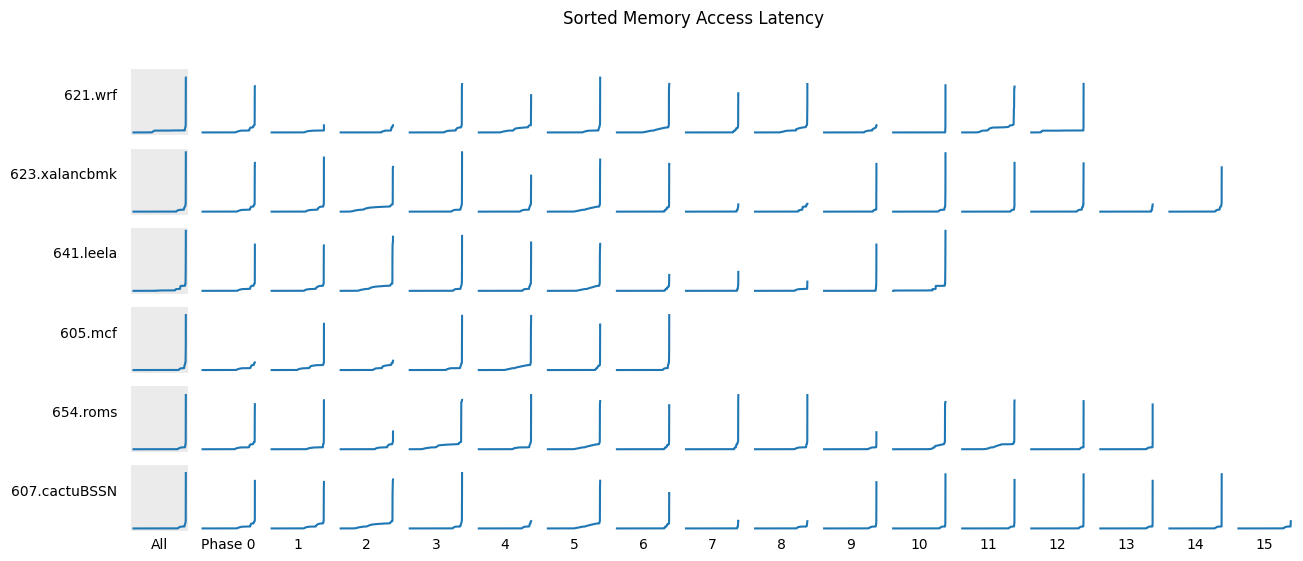

In [178]:
latencyPerPhase(plot4, 'Sorted Memory Access Latency')

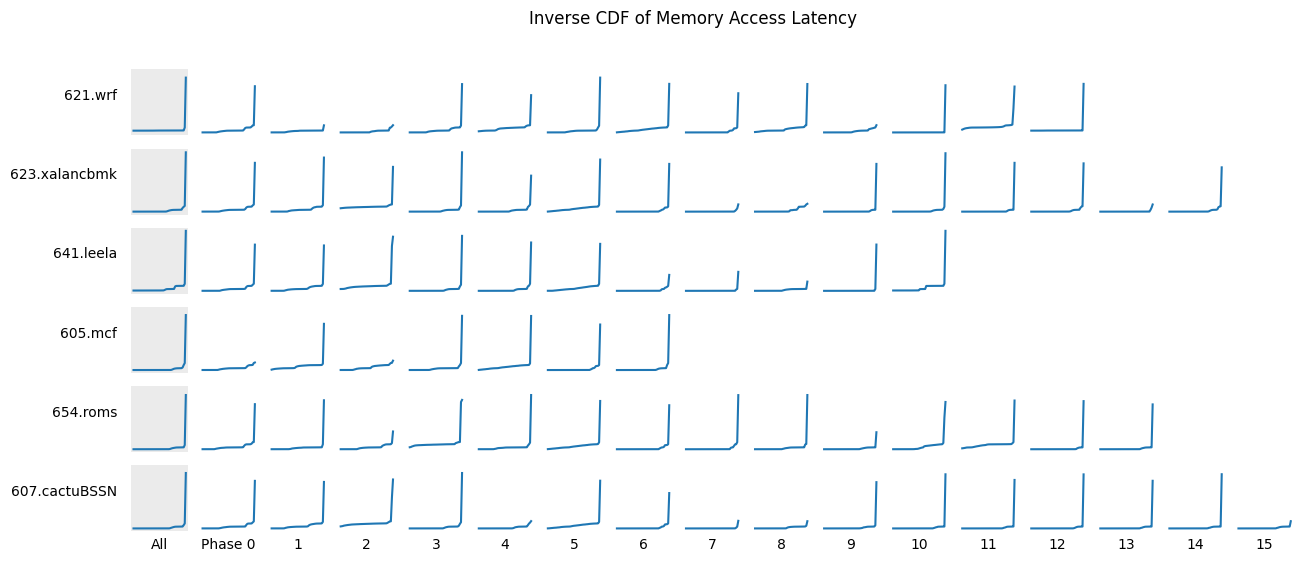

In [196]:
latencyPerPhase(plot_inverse_cdf, 'Inverse CDF of Memory Access Latency')

0.36775545030206813